# Intro

In [1]:
!pip install tensorflow

In [2]:
!pip install joblib

In [ ]:
# url = "https://github.com/algonacci/DataSetBatik/tree/master/CitraBatik"
# roboflow = https://universe.roboflow.com/apriliaagrn/motif-batik-idv6s

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from PIL import Image
from shutil import copy2
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix, f1_score

In [4]:
# pake zip dataset drive
import zipfile
import gdown

url = "https://drive.google.com/uc?export=download&id=1EHf8O8JRtoBUDkcyGB0Lt5MlwPWwM2yb"
output = "Motif_Batik_Dataset.zip"
gdown.download(url, output, quiet=False)

zip_ref = zipfile.ZipFile("/content/Motif_Batik_Dataset.zip", 'r')
zip_ref.extractall("dataset")
zip_ref.close()

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1EHf8O8JRtoBUDkcyGB0Lt5MlwPWwM2yb
From (redirected): https://drive.google.com/uc?export=download&id=1EHf8O8JRtoBUDkcyGB0Lt5MlwPWwM2yb&confirm=t&uuid=b0a834bc-8da0-41a6-9ac8-bca3a75a5525
To: /content/Motif_Batik_Dataset.zip
100%|██████████| 381M/381M [00:03<00:00, 102MB/s]


# Split data train val test

In [5]:
# Define Directories for Dataset
base_dir = r'/content/dataset/New_Motif_Batik_Dataset'

train_dir = r'/content/train'
val_dir = r'/content/val'
test_dir = r'/content/test'

# Create directories for train, val, and test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all class names (folder names)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Create class directories in train, val, and test folders
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

In [6]:
# Split data dan bagi jadi 3 folder baru test, train, val trus diisi
for cls in classes:
    cls_dir = os.path.join(base_dir, cls)
    images = os.listdir(cls_dir)
    images = [img for img in images if os.path.isfile(os.path.join(cls_dir, img))]

    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42) # 0.15
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42) # 0.33

    for img in train_imgs:
        copy2(os.path.join(cls_dir, img), os.path.join(train_dir, cls))
    for img in val_imgs:
        copy2(os.path.join(cls_dir, img), os.path.join(val_dir, cls))
    for img in test_imgs:
        copy2(os.path.join(cls_dir, img), os.path.join(test_dir, cls))

In [7]:
def check_image_shapes(directory):
    shapes = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
                file_path = os.path.join(root, file)
                with Image.open(file_path) as img:
                    shapes.append(img.size)
    return shapes

# Fungsi untuk menghitung jumlah gambar dalam direktori tertentu
def count_images(directory):
    count = 0
    for root, _, files in os.walk(directory):
        count += len([file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))])
    return count

In [8]:
# Mengecek shape gambar di training set
train_shapes = check_image_shapes(train_dir)

# Menampilkan shape gambar dalam training set
print(f"Shape gambar dalam training set: {train_shapes[0]}")

Shape gambar dalam training set: (640, 640)


In [9]:
# # # undersampling

# from imblearn.under_sampling import RandomUnderSampler
# import os
# from shutil import copy2
# import numpy as np
# from PIL import Image

# # Hypothetical feature extraction function
# def extract_features(image_path):
#     try:
#         # Open the image
#         with Image.open(image_path) as img:
#             # Convert the image to grayscale
#             img = img.convert('L')
#             # Resize the image to a fixed size (e.g., 64x64)
#             img = img.resize((64, 64))
#             # Flatten the image to a 1D array
#             features = np.array(img).flatten()
#             return features
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# # Initialize RandomUnderSampler
# undersampler = RandomUnderSampler()

# # Define classes and training directory
# classes = ['Batik Bali', 'Batik Betawi', 'Batik Celup', 'Batik Cendrawasih', 'Batik Dayak', 'Batik Geblek Renteng', 'Batik Insang', 'Batik Kawung',
#            'Batik Lasem', 'Batik Megamendung', 'Batik Pala', 'Batik Parang', 'Batik Poleng', 'Batik Sekar Jagad', 'Batik Tambal']
# train_dir = '/content/train'

# # Check if the training directory exists
# if not os.path.exists(train_dir):
#     print(f"Training directory '{train_dir}' does not exist.")
# else:
#     # Collect all training images and labels from all classes
#     X_train = []
#     y_train = []
#     image_paths = []

#     for cls in classes:
#         train_cls_dir = os.path.join(train_dir, cls)
#         if not os.path.exists(train_cls_dir):
#             print(f"Class directory '{train_cls_dir}' does not exist.")
#             continue  # Skip this class if the directory does not exist

#         train_imgs = os.listdir(train_cls_dir)
#         for img in train_imgs:
#             img_path = os.path.join(train_cls_dir, img)
#             features = extract_features(img_path)
#             if features is not None:
#                 X_train.append(features)
#                 y_train.append(cls)
#                 image_paths.append(img_path)

#     # Convert to numpy arrays
#     X_train = np.array(X_train)
#     y_train = np.array(y_train)

#     # Perform undersampling on the entire training dataset
#     X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

#     # Copy images to the training directory with the undersampled dataset
#     for idx, (features, label) in enumerate(zip(X_train_resampled, y_train_resampled)):
#         original_idx = np.where((X_train == features).all(axis=1))[0][0]
#         original_img_path = image_paths[original_idx]
#         class_name = label
#         destination_dir = os.path.join(train_dir, class_name)

#         if not os.path.exists(destination_dir):
#             os.makedirs(destination_dir)

#         new_img_path = os.path.join(destination_dir, f'undersampled_{idx}.jpg')

#         # Only copy if the new path is different from the original path
#         if new_img_path != original_img_path:
#             copy2(original_img_path, new_img_path)


In [10]:
# oversampling

from imblearn.over_sampling import SMOTE
import os
from shutil import copy2
import numpy as np
from PIL import Image

# Hypothetical feature extraction function
def extract_features(image_path):
    try:
        # Open the image
        with Image.open(image_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')
            # Resize the image to a fixed size
            img = img.resize((224, 224))
            # Flatten the image to a 1D array
            features = np.array(img).flatten()
            return features
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Initialize SMOTE
smote = SMOTE()

# Define classes and training directory
train_dir = '/content/train'
classes = ['Batik Bali', 'Batik Betawi', 'Batik Celup', 'Batik Cendrawasih', 'Batik Dayak', 'Batik Geblek Renteng', 'Batik Insang', 'Batik Kawung',
           'Batik Lasem', 'Batik Mega Mendung', 'Batik Pala', 'Batik Parang', 'Batik Poleng', 'Batik Sekar Jagad', 'Batik Tambal']

# Check if the training directory exists
if not os.path.exists(train_dir):
    print(f"Training directory '{train_dir}' does not exist.")
else:
    # Collect all training images and labels from all classes
    X_train = []
    y_train = []
    image_paths = []

    for cls in classes:
        train_cls_dir = os.path.join(train_dir, cls)
        if not os.path.exists(train_cls_dir):
            print(f"Class directory '{train_cls_dir}' does not exist.")
            continue  # Skip this class if the directory does not exist

        train_imgs = os.listdir(train_cls_dir)
        for img in train_imgs:
            img_path = os.path.join(train_cls_dir, img)
            features = extract_features(img_path)
            if features is not None:
                X_train.append(features)
                y_train.append(cls)
                image_paths.append(img_path)

    if len(X_train) == 0:
        print("No images found for any class. Please check your directories and try again.")
    else:
        # Convert to numpy arrays
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # Perform oversampling on the entire training dataset
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Copy images to the training directory with the oversampled dataset
        for idx, (features, label) in enumerate(zip(X_train_resampled, y_train_resampled)):
            original_idx = idx % len(image_paths)
            original_img_path = image_paths[original_idx]
            class_name = label
            destination_dir = os.path.join(train_dir, class_name)

            if not os.path.exists(destination_dir):
                os.makedirs(destination_dir)

            new_img_path = os.path.join(destination_dir, f'oversampled_{idx}.jpg')

            # Only copy if the new path is different from the original path
            if new_img_path != original_img_path:
                copy2(original_img_path, new_img_path)

        print("Oversampling completed successfully.")

Oversampling completed successfully.


In [11]:
TRAINING_DIR = r'/content/train'
train_datagen = ImageDataGenerator(
                    rescale = 1.0 / 255.0,
                    rotation_range = 40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    zoom_range= 0.2,
                    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)

VALIDATION_DIR = r'/content/val'
val_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)

TESTING_DIR = r'/content/test'
test_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

testing_generator = test_datagen.flow_from_directory(
    TESTING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)

Found 8464 images belonging to 15 classes.
Found 501 images belonging to 15 classes.
Found 512 images belonging to 15 classes.


# CNN

In [ ]:
# Transfer Learning

# base_model = tf.keras.applications.VGG16(include_top=False,
#                                          weights='imagenet',
#                                          input_shape=(380, 380, 3))
# base_model.trainable = False

Pembuatan model CNN pada keras mirip dengan pembuatan model Multi Layer Perceptron (MLP) yang dibahas pada modul sebelumnya. Perbedaannya terdapat pada empat lapis layer konvolusi dan max pooling.

In [ ]:
# num_classes = 15  # ada 15 class

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu', input_shape=(380, 380, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Conv2D(256, (3, 3), 1, activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),

#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dense(num_classes, activation='softmax')  # num_classes should be > 1 for multi-class classification
# ])

# model.summary()

# Transfer Learning

In [12]:
# # VERSI 1
# # jumlah kelas
# num_classes = 15

# # ukuran input shape
# input_shape = (224, 224, 3)  # Assuming you're using VGG16 which requires 224x224 images

# # Load the pre-trained VGG16 model (include_top=False to exclude the fully connected layers)
# base_model = tf.keras.applications.VGG16(include_top=False,
#                                          weights='imagenet',
#                                          input_shape=(224, 224, 3))
# base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# # Freeze the pre-trained layers so they're not updated during training
# for layer in base_model.layers:
#     layer.trainable = False

# # Unfreeze beberapa lapisan terakhir
# # for layer in base_model.layers[-4:]:  # Membuka freeze 4 lapisan terakhir
# #     layer.trainable = True

# # Global Average Pooling layer can be used instead of Flatten
# # x = GlobalAveragePooling2D()(x)

# # ------------------------------------------------------------MODEL 1-----------------------------------------------------------------------------------------------
# # Add new fully connected layers on top of the pre-trained layers
# x = base_model.output
# x = Conv2D(512, (3, 3), activation='relu')(x)
# # x = MaxPooling2D((2, 2))(x)
# x = Flatten()(x)
# x = Dense(1024, activation = "relu")(x)
# x = Dropout(0.2)(x)
# predictions = Dense(num_classes, activation='softmax')(x)

# # ------------------------------------------------------------MODEL 2-----------------------------------------------------------------------------------------------
# # model = tf.keras.Sequential([
# #     base_model,
# #     tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
# #     tf.keras.layers.MaxPooling2D(2, 2),
# #     tf.keras.layers.Conv2D(256, (3, 3), padding = 'same', activation = 'relu'),
# #     tf.keras.layers.MaxPooling2D(2, 2),
# #     tf.keras.layers.Flatten(),
# #     tf.keras.layers.GlobalAveragePooling2D(),
# #     tf.keras.layers.Dropout(0.2),
# #     tf.keras.layers.Dense(num_classes, activation='softmax')
# # ])

# # Create the final model
# model = Model(inputs=base_model.input, outputs=predictions)

# # Callbacks
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks = [
#     ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
#     EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min')
# ]

In [13]:
# VERSI 2

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# jumlah kelas
num_classes = 15

# ukuran input shape
input_shape = (224, 224, 3)  # Assuming you're using VGG16 which requires 224x224 images

# Load the pre-trained VGG16 model (include_top=False to exclude the fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers so they're not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Define your top layers
x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(base_model.output)
# x = tf.keras.layers.MaxPooling2D(2, 2)(x)
# x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(2, 2)(x)
# x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(2, 2)(x)
# x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x) # atau 0.2
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min')
]

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [14]:
# # VERSI 3

# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import EfficientNetV2M

# # jumlah kelas
# num_classes = 15
# input_shape = (224, 224, 3)

# base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=input_shape)

# for layer in base_model.layers:
#     layer.trainable = False

# # Define your top layers
# x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(base_model.output)
# x = tf.keras.layers.MaxPooling2D(2, 2)(x)
# x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(2, 2)(x)
# x = tf.keras.layers.Flatten()(x)
# # x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.5)(x) # atau 0.2
# predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# # Create the final model
# model = Model(inputs=base_model.input, outputs=predictions)
# model.summary()

# # Callbacks
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks = [
#     ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
#     EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min')
# ]

kalo param gede mbnya mungkin,
Regularisasi: Menggunakan teknik regularisasi seperti dropout, L2 regularization, atau early stopping untuk mengurangi risiko overfitting.

Data Augmentation: Meningkatkan ukuran dan keragaman dataset dengan teknik data augmentation untuk membantu model generalisasi lebih baik.

Model Compression:Menggunakan teknik kompresi model seperti pruning, quantization, atau distillation untuk mengurangi ukuran model tanpa mengorbankan performa secara signifikan.

In [15]:
'''
tahap selanjutnya adalah melakukan compile model tersebut menggunakan fungsi compile(). Pada tahap ini, kita juga menentukan loss function serta optimizer yang akan digunakan.
Selain itu, optimizer yang digunakan  pada kasus ini adalah "Adam optimizer".
Adam optimizer dipilih karena mudah diterapkan, lebih efisien secara komputasi dan kebutuhan memori yang lebih kecil.
'''
from keras.optimizers import Adam
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # atau 0.0005
              metrics = ['accuracy'])


In [16]:
# menghitung step per epochnya

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 66
Validation steps: 3


In [17]:
# latih model dengan model.fit
# logdir = "logs"
# tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

Epoch 1/20
66/66 [==============================] - 173s 2s/step - loss: 2.1407 - accuracy: 0.3277 - val_loss: 1.4704 - val_accuracy: 0.5182 - lr: 1.0000e-04
Epoch 2/20
66/66 [==============================] - 145s 2s/step - loss: 1.4559 - accuracy: 0.5446 - val_loss: 1.1129 - val_accuracy: 0.6354 - lr: 1.0000e-04
Epoch 3/20
66/66 [==============================] - 143s 2s/step - loss: 1.2422 - accuracy: 0.6195 - val_loss: 1.0706 - val_accuracy: 0.6641 - lr: 1.0000e-04
Epoch 4/20
66/66 [==============================] - 146s 2s/step - loss: 1.1081 - accuracy: 0.6672 - val_loss: 0.8617 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 5/20
66/66 [==============================] - 153s 2s/step - loss: 0.9663 - accuracy: 0.7103 - val_loss: 0.8306 - val_accuracy: 0.7630 - lr: 1.0000e-04
Epoch 6/20
66/66 [==============================] - 142s 2s/step - loss: 0.8973 - accuracy: 0.7362 - val_loss: 0.6912 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 7/20
66/66 [==============================] - 

# Import ke Tflite, Json, H5, tfjs

In [ ]:
# import ke h5

model.save("model.h5")

In [ ]:
# import ke tflite
model = tf.keras.models.load_model("model.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_tflite = converter.convert()

# Save the converted model to a .tflite file
with open("CNN_TransferLearningModel.tflite", "wb") as f:
    f.write(model_tflite)

In [ ]:
# import ke json

import json

model = tf.keras.models.load_model("model.h5")

# Save the model architecture to a JSON file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
!pip install tensorflowjs

In [ ]:
# import ke tfjs

model = tf.keras.models.load_model("model.h5")

!tensorflowjs_converter --input_format=keras {saved_model_path} ./
!zip filebin.zip *.bin model.json

# Cek Grafik

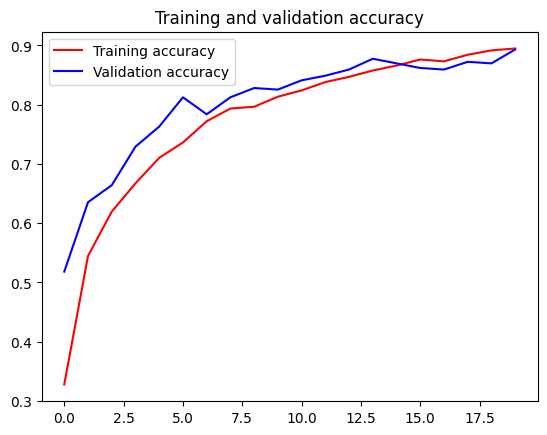

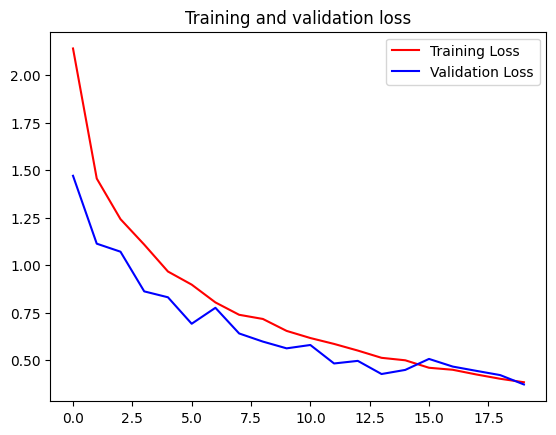

In [18]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Tes Prediksi

In [19]:
# Melakukan Prediksi
testing_steps = testing_generator.samples // testing_generator.batch_size
predictions = model.predict(testing_generator, steps=testing_steps)

# Evaluasi model pada dataset testing
test_loss, test_acc = model.evaluate(testing_generator, steps=testing_generator.samples // testing_generator.batch_size)
print(f'Test accuracy: {test_acc}')

# Atau jika Anda hanya ingin melakukan prediksi pada dataset testing
predictions = model.predict(testing_generator, steps=testing_generator.samples // testing_generator.batch_size)


4/4 [==============================] - 3s 738ms/step - loss: 0.4652 - accuracy: 0.8730
Test accuracy: 0.873046875
4/4 [==============================] - 2s 632ms/step


In [23]:
motives_dict = train_generator.class_indices
print(motives_dict)

{'Batik Bali': 0, 'Batik Betawi': 1, 'Batik Celup': 2, 'Batik Cendrawasih': 3, 'Batik Dayak': 4, 'Batik Geblek Renteng': 5, 'Batik Insang': 6, 'Batik Kawung': 7, 'Batik Lasem': 8, 'Batik Mega Mendung': 9, 'Batik Pala': 10, 'Batik Parang': 11, 'Batik Poleng': 12, 'Batik Sekar Jagad': 13, 'Batik Tambal': 14}


In [33]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

test_dir = '/content/test'

for motive in motives_dict.keys():
    images_list = os.listdir(os.path.join(test_dir, motive))
    correct_count = 0

    for image in images_list:
        img_path = os.path.join(test_dir, motive, image)
        img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        motives_list = list(motives_dict.keys())
        prediction = model(img_array)
        pred_idx = np.argmax(prediction)
        pred_motive = motives_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_motive == motive:
            correct_count += 1

    total_images = len(images_list)
    print(f'{motive} Predictions --> {correct_count}/{total_images} correct')

Batik Bali Predictions --> 11/34 correct
Batik Betawi Predictions --> 7/35 correct
Batik Celup Predictions --> 31/38 correct
Batik Cendrawasih Predictions --> 6/34 correct
Batik Dayak Predictions --> 12/34 correct
Batik Geblek Renteng Predictions --> 12/34 correct
Batik Insang Predictions --> 6/34 correct
Batik Kawung Predictions --> 18/34 correct
Batik Lasem Predictions --> 12/35 correct
Batik Mega Mendung Predictions --> 33/35 correct
Batik Pala Predictions --> 23/33 correct
Batik Parang Predictions --> 12/34 correct
Batik Poleng Predictions --> 27/31 correct
Batik Sekar Jagad Predictions --> 25/33 correct
Batik Tambal Predictions --> 15/34 correct


# Evaluasi Model

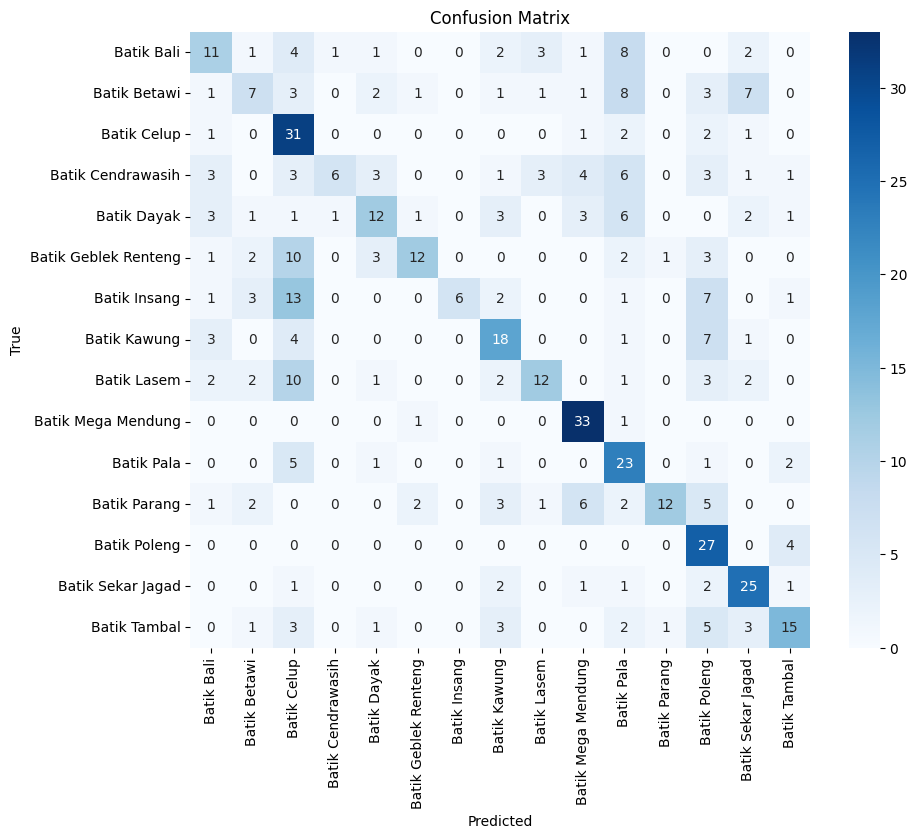

In [36]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_dir = '/content/test'
motives_list = list(motives_dict.keys())

true_labels = []
pred_labels = []

for motive in motives_dict.keys():
    images_list = os.listdir(os.path.join(test_dir, motive))

    for image in images_list:
        img_path = os.path.join(test_dir, motive, image)
        img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        prediction = model(img_array)
        pred_idx = np.argmax(prediction)
        pred_motive = motives_list[pred_idx]

        true_labels.append(motive)
        pred_labels.append(pred_motive)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=motives_list)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=motives_list, yticklabels=motives_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [37]:
# Calculate F1 score
f1 = f1_score(true_labels, pred_labels, labels=motives_list, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')

# Display classification report
report = classification_report(true_labels, pred_labels, target_names=motives_list)
print('Classification Report:')
print(report)

Weighted F1 Score: 0.46
Classification Report:
                      precision    recall  f1-score   support

          Batik Bali       0.41      0.32      0.36        34
        Batik Betawi       0.37      0.20      0.26        35
         Batik Celup       0.35      0.82      0.49        38
   Batik Cendrawasih       0.75      0.18      0.29        34
         Batik Dayak       0.50      0.35      0.41        34
Batik Geblek Renteng       0.71      0.35      0.47        34
        Batik Insang       1.00      0.18      0.30        34
        Batik Kawung       0.47      0.53      0.50        34
         Batik Lasem       0.60      0.34      0.44        35
  Batik Mega Mendung       0.66      0.94      0.78        35
          Batik Pala       0.36      0.70      0.47        33
        Batik Parang       0.86      0.35      0.50        34
        Batik Poleng       0.40      0.87      0.55        31
   Batik Sekar Jagad       0.57      0.76      0.65        33
        Batik Tambal  

# Config

In [ ]:
# model config pake h5
import h5py

# Replace 'your_model_name' with the actual file name of your HDF5 file
file_name = 'model.h5'

# Open the HDF5 file in read mode
with h5py.File(file_name, 'r') as f:
    # Retrieve the 'model_config' attribute
    model_config = f.attrs.get('model_config')

# Print the model configuration
print(model_config)